## **Final Project**

### Step 1: Gather data, determine the method of data collection and provenance of the data (3 points)

#### ***Data Source and Collection***

For my project, I have elected to use Spotify's data to understand a bit more about the types of music available on the platform. I am a music lover and spend several hours a day listening to material on the platform. While I do not have access to summary data on my own listening data (that apparently takes significant lead time to request), I was able to find data on Kaggle collected by Turkish Data Scientist Yamaç Eren Ay using the Spotify Web API that is [available for download here](https://www.kaggle.com/datasets/fcpercival/160k-spotify-songs-sorted).

This data contains over 160,000 tracks sorted by names from 1921 through 2020. Each row contains a track with associated information such as tempo, artist, release data, as well as certain data generated by a Spotify algorithm measuring things such as danceability. The nature of that algorithm will not be a focus of this paper but is acknowledged as a potential limitation of this brief research. We can use Spotify's danceability feature but have to rely on their interpretation of its meaning. This is something to keep in mind when interpreting our results.

Note that while others have certainly used this dataset for their own research purposes, I will not be duplicating their work. I will be downloading the dataset and attempting to start fresh.

### Step 2: Identify an Unsupervised Learning Problem (6 points)

#### ***Problem Statement***

The massive amount of songs and and the wide variety of artists available on Spotify is a classic example of the tyranny of choice. While there is clearly a lot of quality content, identifying the right content for the right user is far from simple. ML techniques can help us identify patterns and connections in the data that might not be apparent to us. We can then use this information to help recommend tracks for users, generate playlists, understand trends, or even guide what music gets produced.

My goal is to apply unsupervised learning techniques to analyze Spotify data. In particular my plan is as follows:

1. Perform EDA to shape my analysis
2. Perform **Clustering** based on their features to identify meaningful groupings of songs
3. Do Non-negative Matrix Factorization (NMF) to attempt to decompose the set into latent factors. This may not be successful, but it will be interesting to look at (and could certainly be insightful if we find something positive).

While I consider this more exploratory than hypothesis-testing

Please note that NMF is more likely to be succesful here than when working with our Netflix movie class example since we are not dealing with a very sparse matrix of movie reviews. This is a matrix of all songs and information about them. While I will explore the matrix more shortly, I expect that this will be a fuller matrix and will avoid some of the issues we encountered earlier of using NMF on a spare matrix.




### Step 3 Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (26 points)

We start this section by importing the necessary libraries, which I assume you have installed. Please do so before running this to avoid any issues. I have the data saved locally, but you can download it from the link provided above.



In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# Load the dataset
spot = pd.read_csv('/content/data.csv')

### "Instructions: Describing the Factors of the Dataset"

The dataframe consists of 169,907 rows and 19 columns. The id is not used as the index presently. I may change that, although it appears to be a bit unusual, so I'm inclined to use a more standard ordinal ID. The other columns are a more standard mixture of ints, floats, and strings (the object Dtype).


Importantly, there are also no null values at all, which can be confirmed by uncommenting the line below. The exact details of what each variable represents are [here in the Spotify developers' guide](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), although Popularity is located in a [separate section here](https://developer.spotify.com/documentation/web-api/reference/get-track).

I choose to start my EDA by looking at histograms of the numerical features, but note that some columns with numerical values may best be considered categorical values. For example, key is what note of the scale and mode is major or minor. As such we will not look at the distribution of these variables but will treat them as categorical ones. The truly numerical features are the ones below. These will be explored more below.

numerical_features = ['duration_ms', 'acousticness', 'danceability', 'energy',
                      'instrumentalness', 'liveness', 'loudness',
                      'speechiness', 'tempo', 'valence', 'popularity']

In [107]:
print(spot.info())
#spot.isnull().sum()
#print(spot.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169907 entries, 0 to 169906
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                169907 non-null  object 
 1   name              169907 non-null  object 
 2   artists           169907 non-null  object 
 3   duration_ms       169907 non-null  int64  
 4   release_date      169907 non-null  object 
 5   year              169907 non-null  int64  
 6   acousticness      169907 non-null  float64
 7   danceability      169907 non-null  float64
 8   energy            169907 non-null  float64
 9   instrumentalness  169907 non-null  float64
 10  liveness          169907 non-null  float64
 11  loudness          169907 non-null  float64
 12  speechiness       169907 non-null  float64
 13  tempo             169907 non-null  float64
 14  valence           169907 non-null  float64
 15  mode              169907 non-null  int64  
 16  key               16

### Distributions of Features

I've made histograms with an overlaid KDE for all the 11 explicitly numeric features (excluding the pseudo-numeric categories where key is represented by a number for example). These are extremely varied and show normal, non-normal, skewed, bimodal, etc. Three graphs that did strike me as noteworthy:

1. Instrumentalness is clustered around 0, which indicates that most tracks are NOT purely instrumental. This makes sense given the preponderance of vocal music
2. Speechiness (while higher than instrumentalness) is still close to zero, indicating that spoken word is more common than pure instruments but still quite rare
3. Popularity is clustered close to 0, indicating that the majority of spotify is more obscure or rarely enjoyed content.

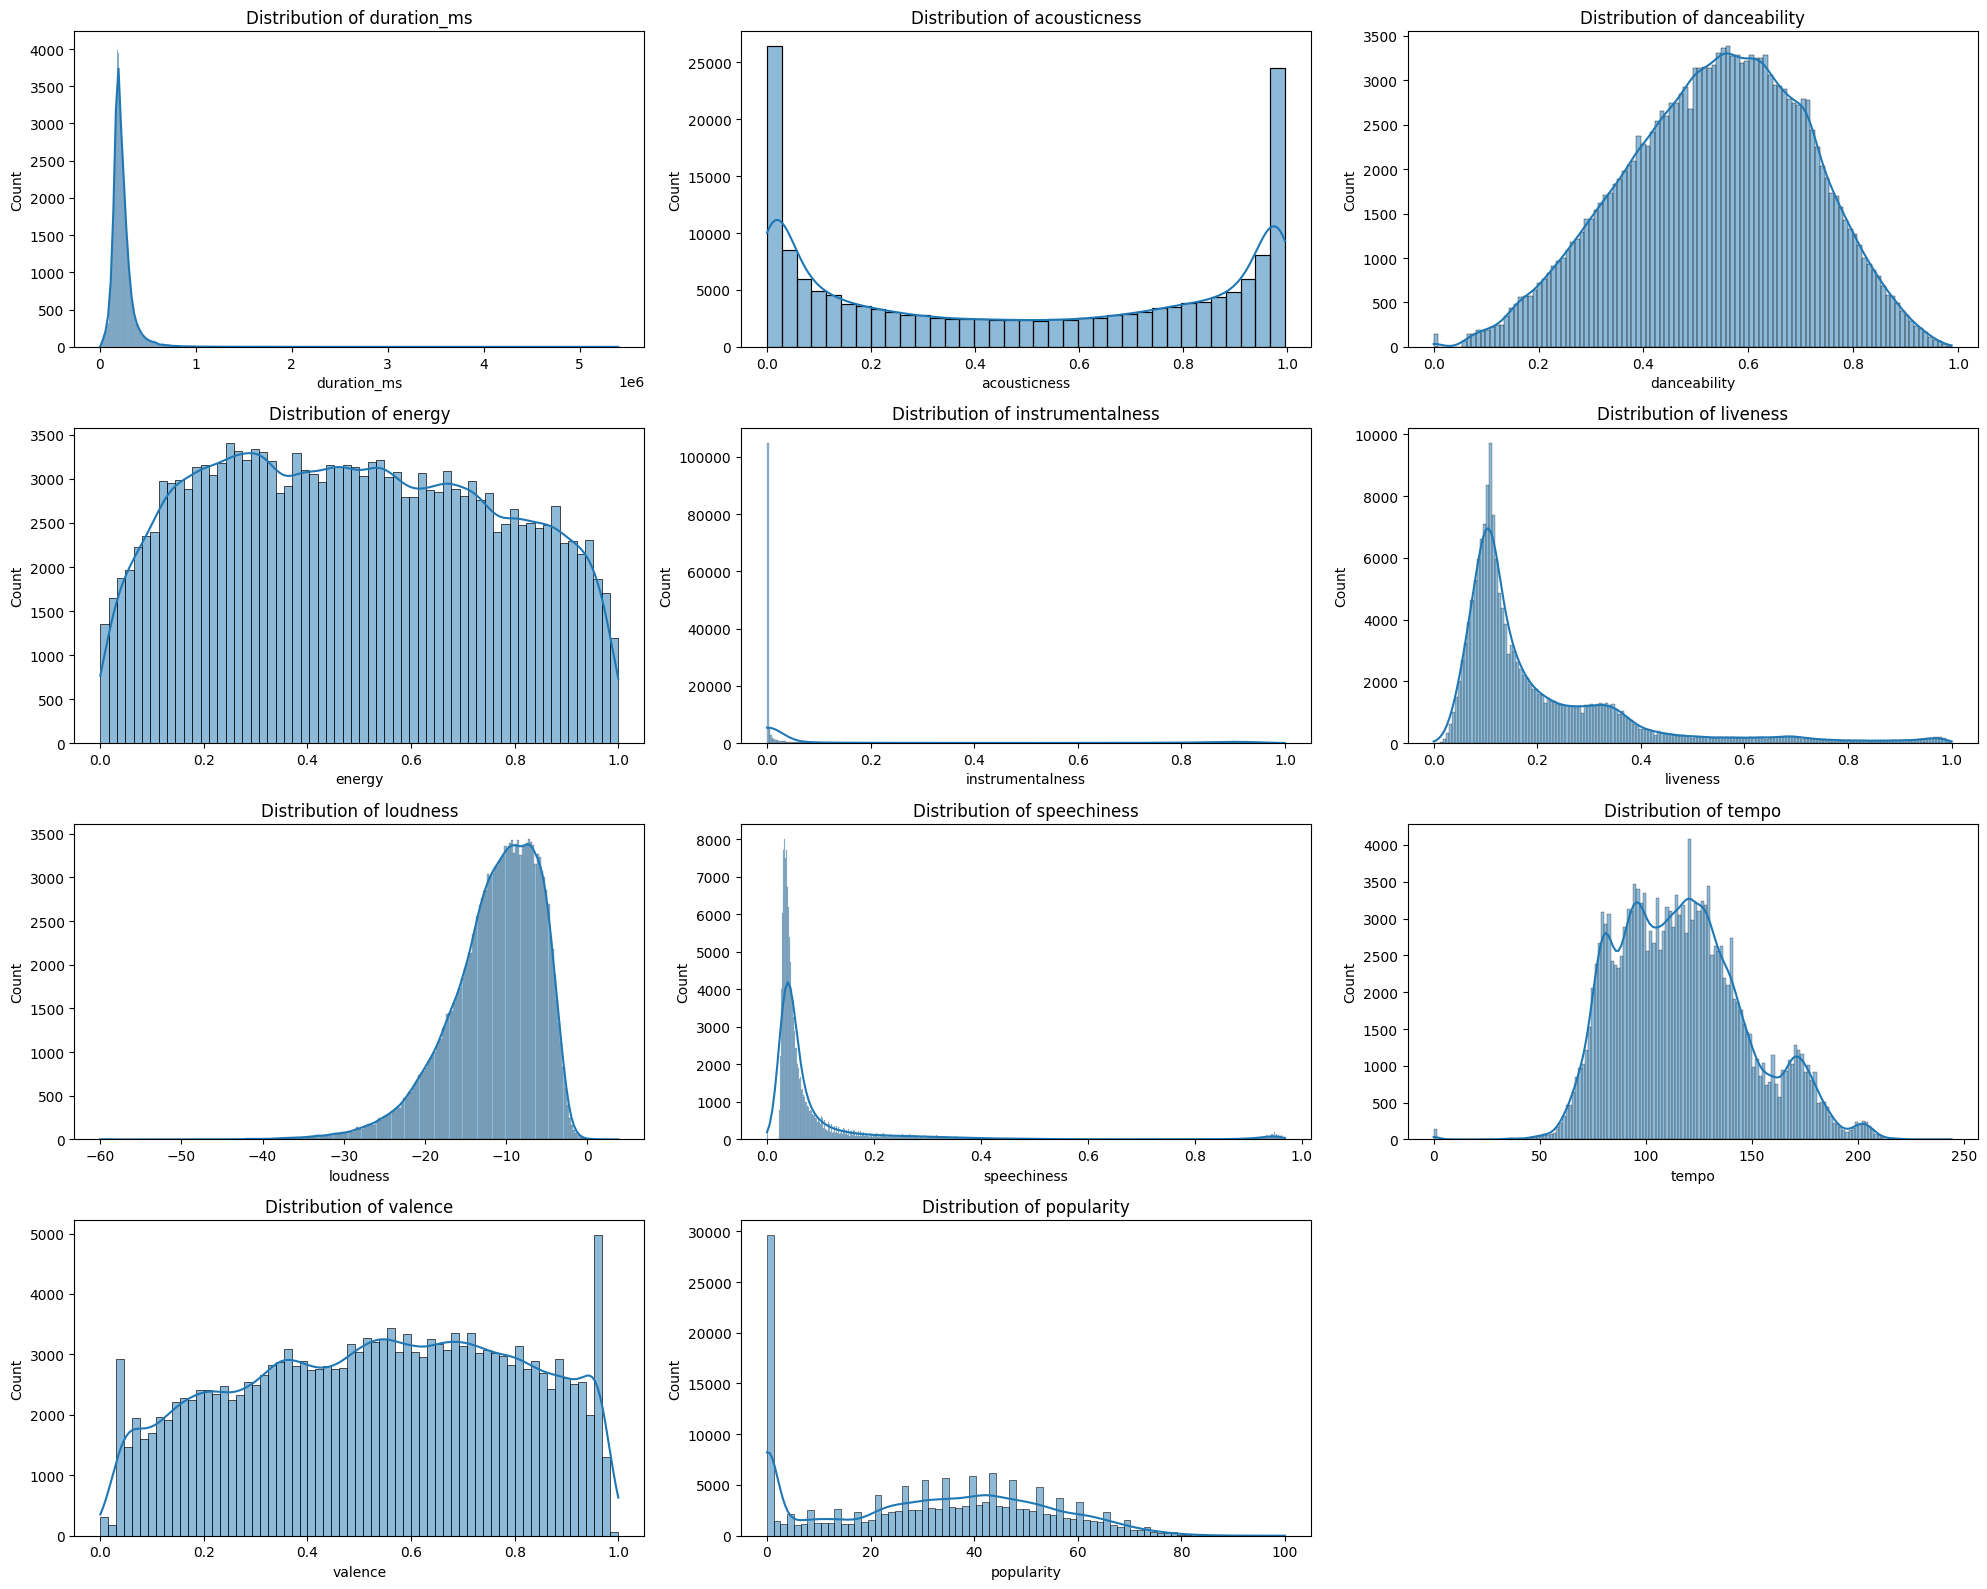

In [108]:
numerical_features = ['duration_ms', 'acousticness', 'danceability', 'energy',
                      'instrumentalness', 'liveness', 'loudness',
                      'speechiness', 'tempo', 'valence', 'popularity']

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy iteration

# Plot histograms with KDE for each feature
for i, feature in enumerate(numerical_features):
    sns.histplot(spot[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Hide any unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

### "Instructions: Describe Correlations"

Coruscating Correlations or "How I Learned to Love the Heatmap"

The correlations vary between -0.75 to +0.78 and while some features are unsurprising, others are a bit strange. A few observations:

1. Acousticness and energy and strongly inversely correlated (-0.75), which seems plausible given lack of amplication
2. Energy and loudness have the highest correlation (0.78), which makes sense to me
3. Energy, loudness, and danceability are the most highly correlated with popularity, which is a bit surprising to me.

It is worth noting however that popularity is highly skewed towards 0, so we should be cautious when drawing conclusions here.

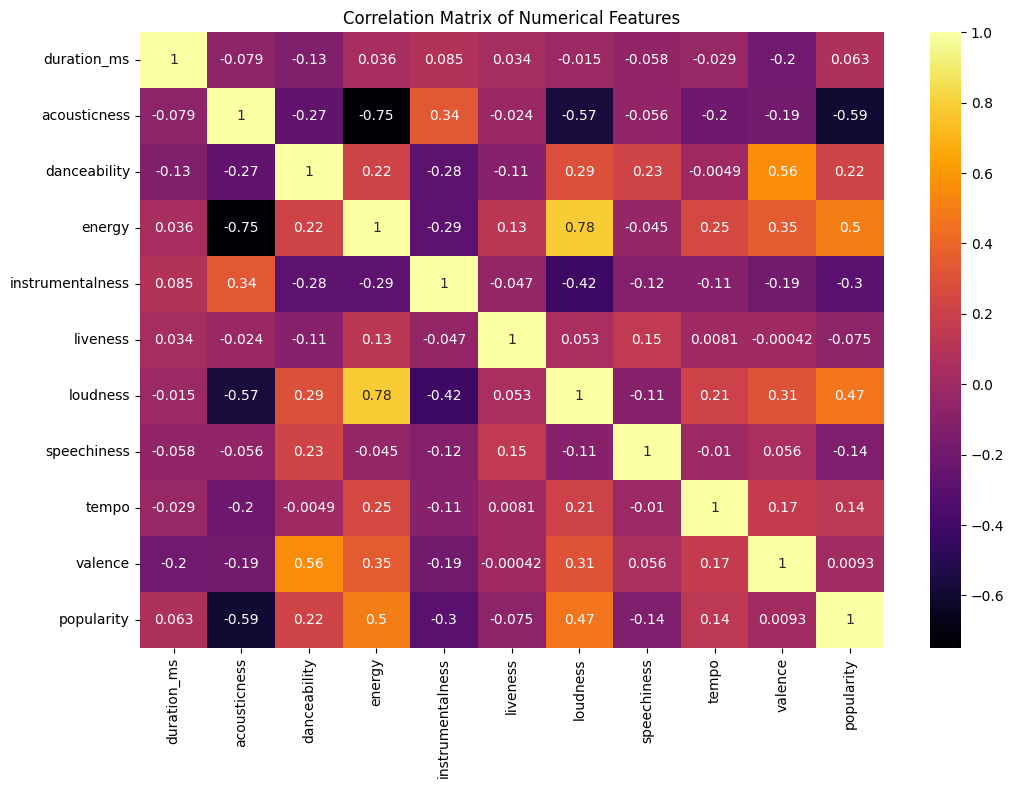

In [109]:
# Correlation matrix and heatmap
corr_matrix = spot[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix of Numerical Features');

###"Instructions: Determine if any data needs to be transformed."""


###"Instructions: Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset."

Many of the numerical values are already between 0 and 1, although not popularity (which goes from 0 to 100), tempo (0 to roughly 250 bpm), loudness (-60 to 3.5), and duration (which goes from a few seconds to 90 minutes). I would recommend we do two things:

1. Take the log of duration to make that a slightly more normal endeavor
2. Normalize all between 0 and 1 to simplify the math

Note that some features appear to be highly correlated, so it may help to do some sort of dimensionality reduction, but for now this should be a good first step. We can do PCA later as needed (and NMF already has a dimensionality component to begin with).

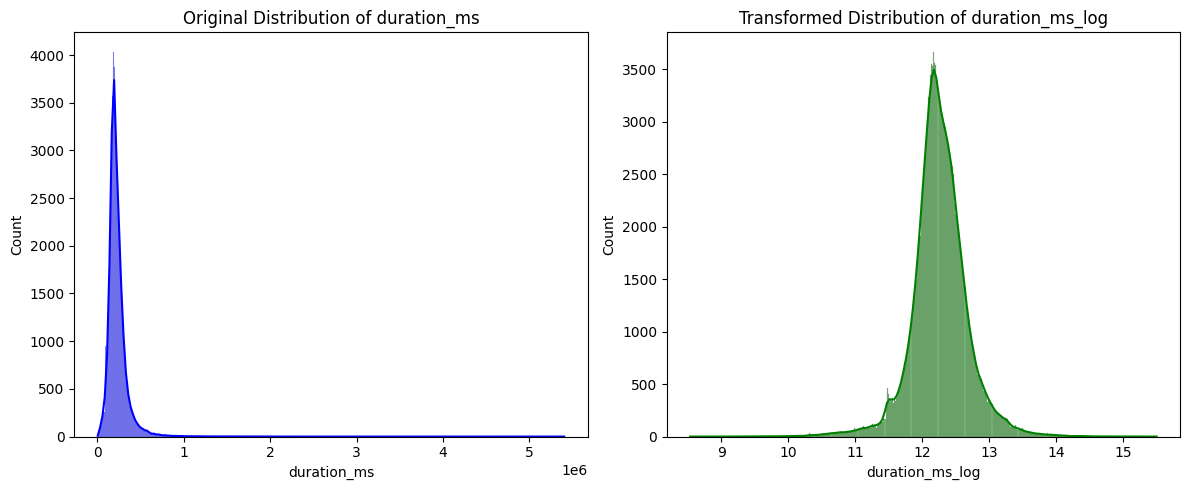

In [110]:
spot['duration_ms_log'] = np.log1p(spot['duration_ms'])

# Original vs Transformed distributions
plt.figure(figsize=(12, 5))

# Plot original feature
plt.subplot(1, 2, 1)
sns.histplot(spot['duration_ms'], kde=True, color='blue')
plt.title('Original Distribution of duration_ms')

# Plot transformed feature
plt.subplot(1, 2, 2)
sns.histplot(spot['duration_ms_log'], kde=True, color='green')
plt.title('Transformed Distribution of duration_ms_log')

plt.tight_layout()
plt.show()

### But first we need to check for outliers!

####"You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?"



Before we normalize though, we need to check for outliers. We've already transformed duration to make it easier to work with but need to see if there are any outliers. A few charts stick out.

1. Danceability has a few zeros, but that is probably appropriate for some pieces (Cage 4'33 comes to mind). Upon inspection, most of these appear to be white noise or other non-musical sounds, so this categorization seems broadly accurate. A few appear to be miscategorized, but given the size of the dataset, I'm inclined to tolerate a slight amount of inaccuracy for the purposes of this project.
2. Similarly tempo of zero is mostly white noise and things like that, which doesn't suggest a problem
3. Loudness has a weird distribution from -60 to 3.5, representing deviation from a baseline decibel level. While it normally ranges from -60 to 0, there are some small exceptions that appear to just be a small deviation rather than a massive error

Based on this reading, I'm inclined to keep the values in the dataset. I will normalize them but retain all of them.

In [111]:
#spot[spot['danceability']==0]
#spot[spot['loudness']==-60]
#spot[spot['tempo']==0]

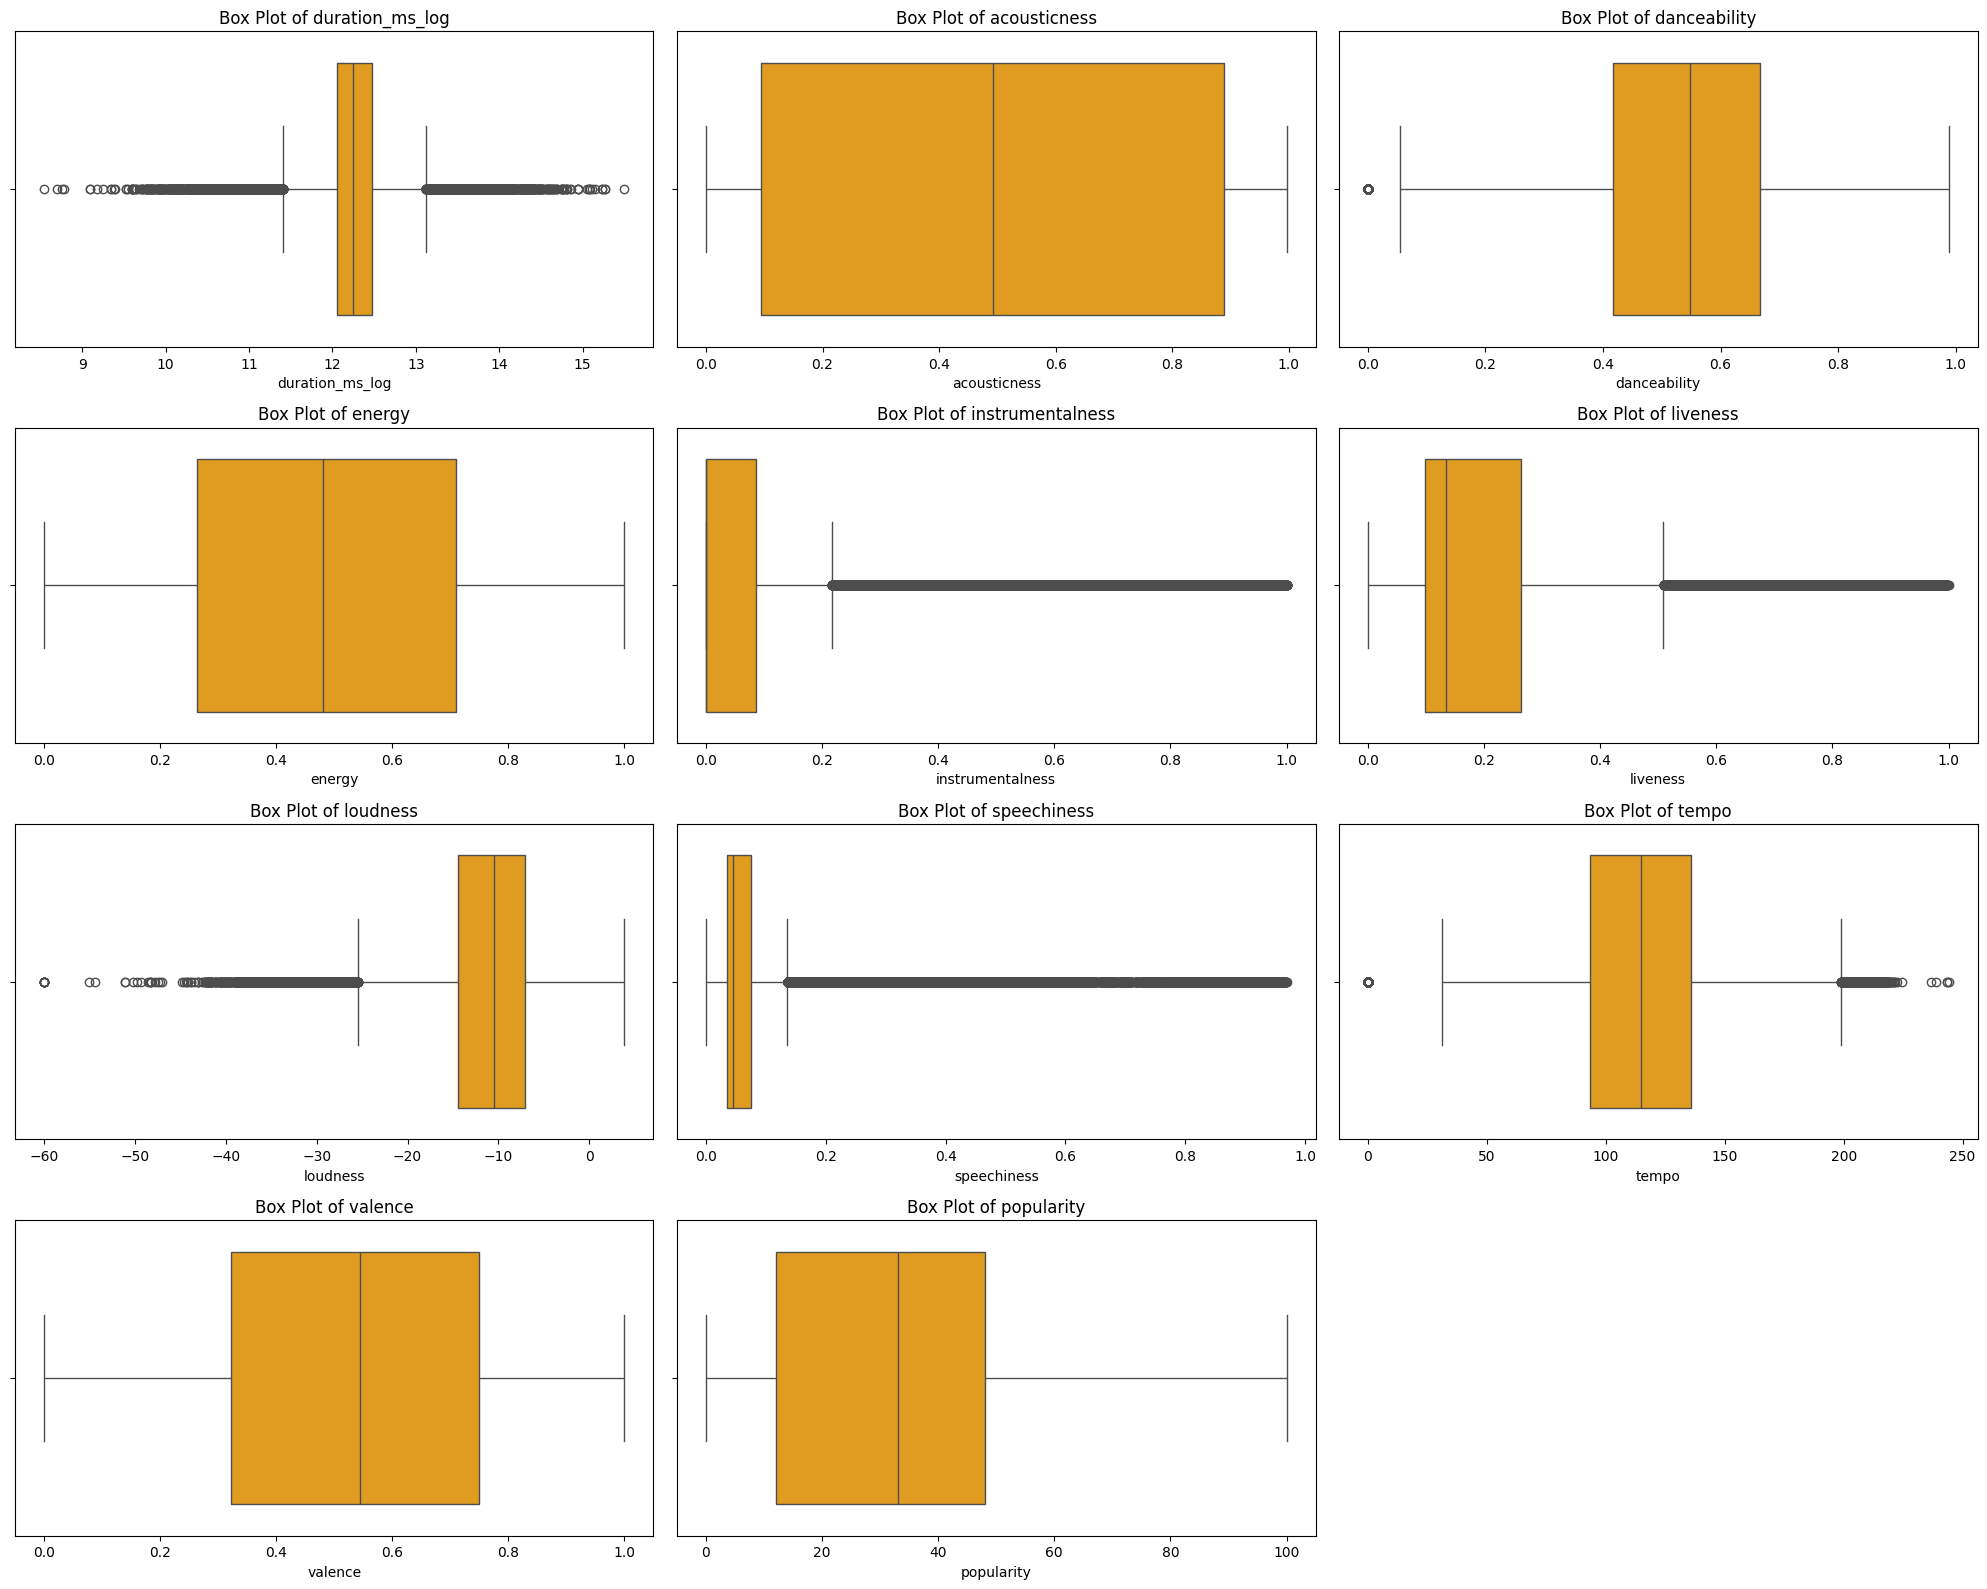

In [112]:
new_numerical_features = ['duration_ms_log', 'acousticness', 'danceability', 'energy',
                      'instrumentalness', 'liveness', 'loudness',
                      'speechiness', 'tempo', 'valence', 'popularity']

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for iteration

# Plot box plots for each feature
for i, feature in enumerate(new_numerical_features):
    sns.boxplot(x=spot[feature], color='orange', ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

# Hide any unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

### Normalizing the Features

Below is the result of normalizing the features to 0 to 1.

Question: "If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up"

Energy, loudness, and danceability seem to show a lot of correlation, which will be significant in clustering and in dimensionality reduction with NMF. This might be something to look at in the next step of our analysis. In addition, we also want to look how these tracks impact popularity. While popularity is heavily skewed towards 0, these three factors appear to be quite influential in determining popularity. As such, I will be very interested to see how these factors perform and evolve in the next step of the analysis, which is Part 4: Models


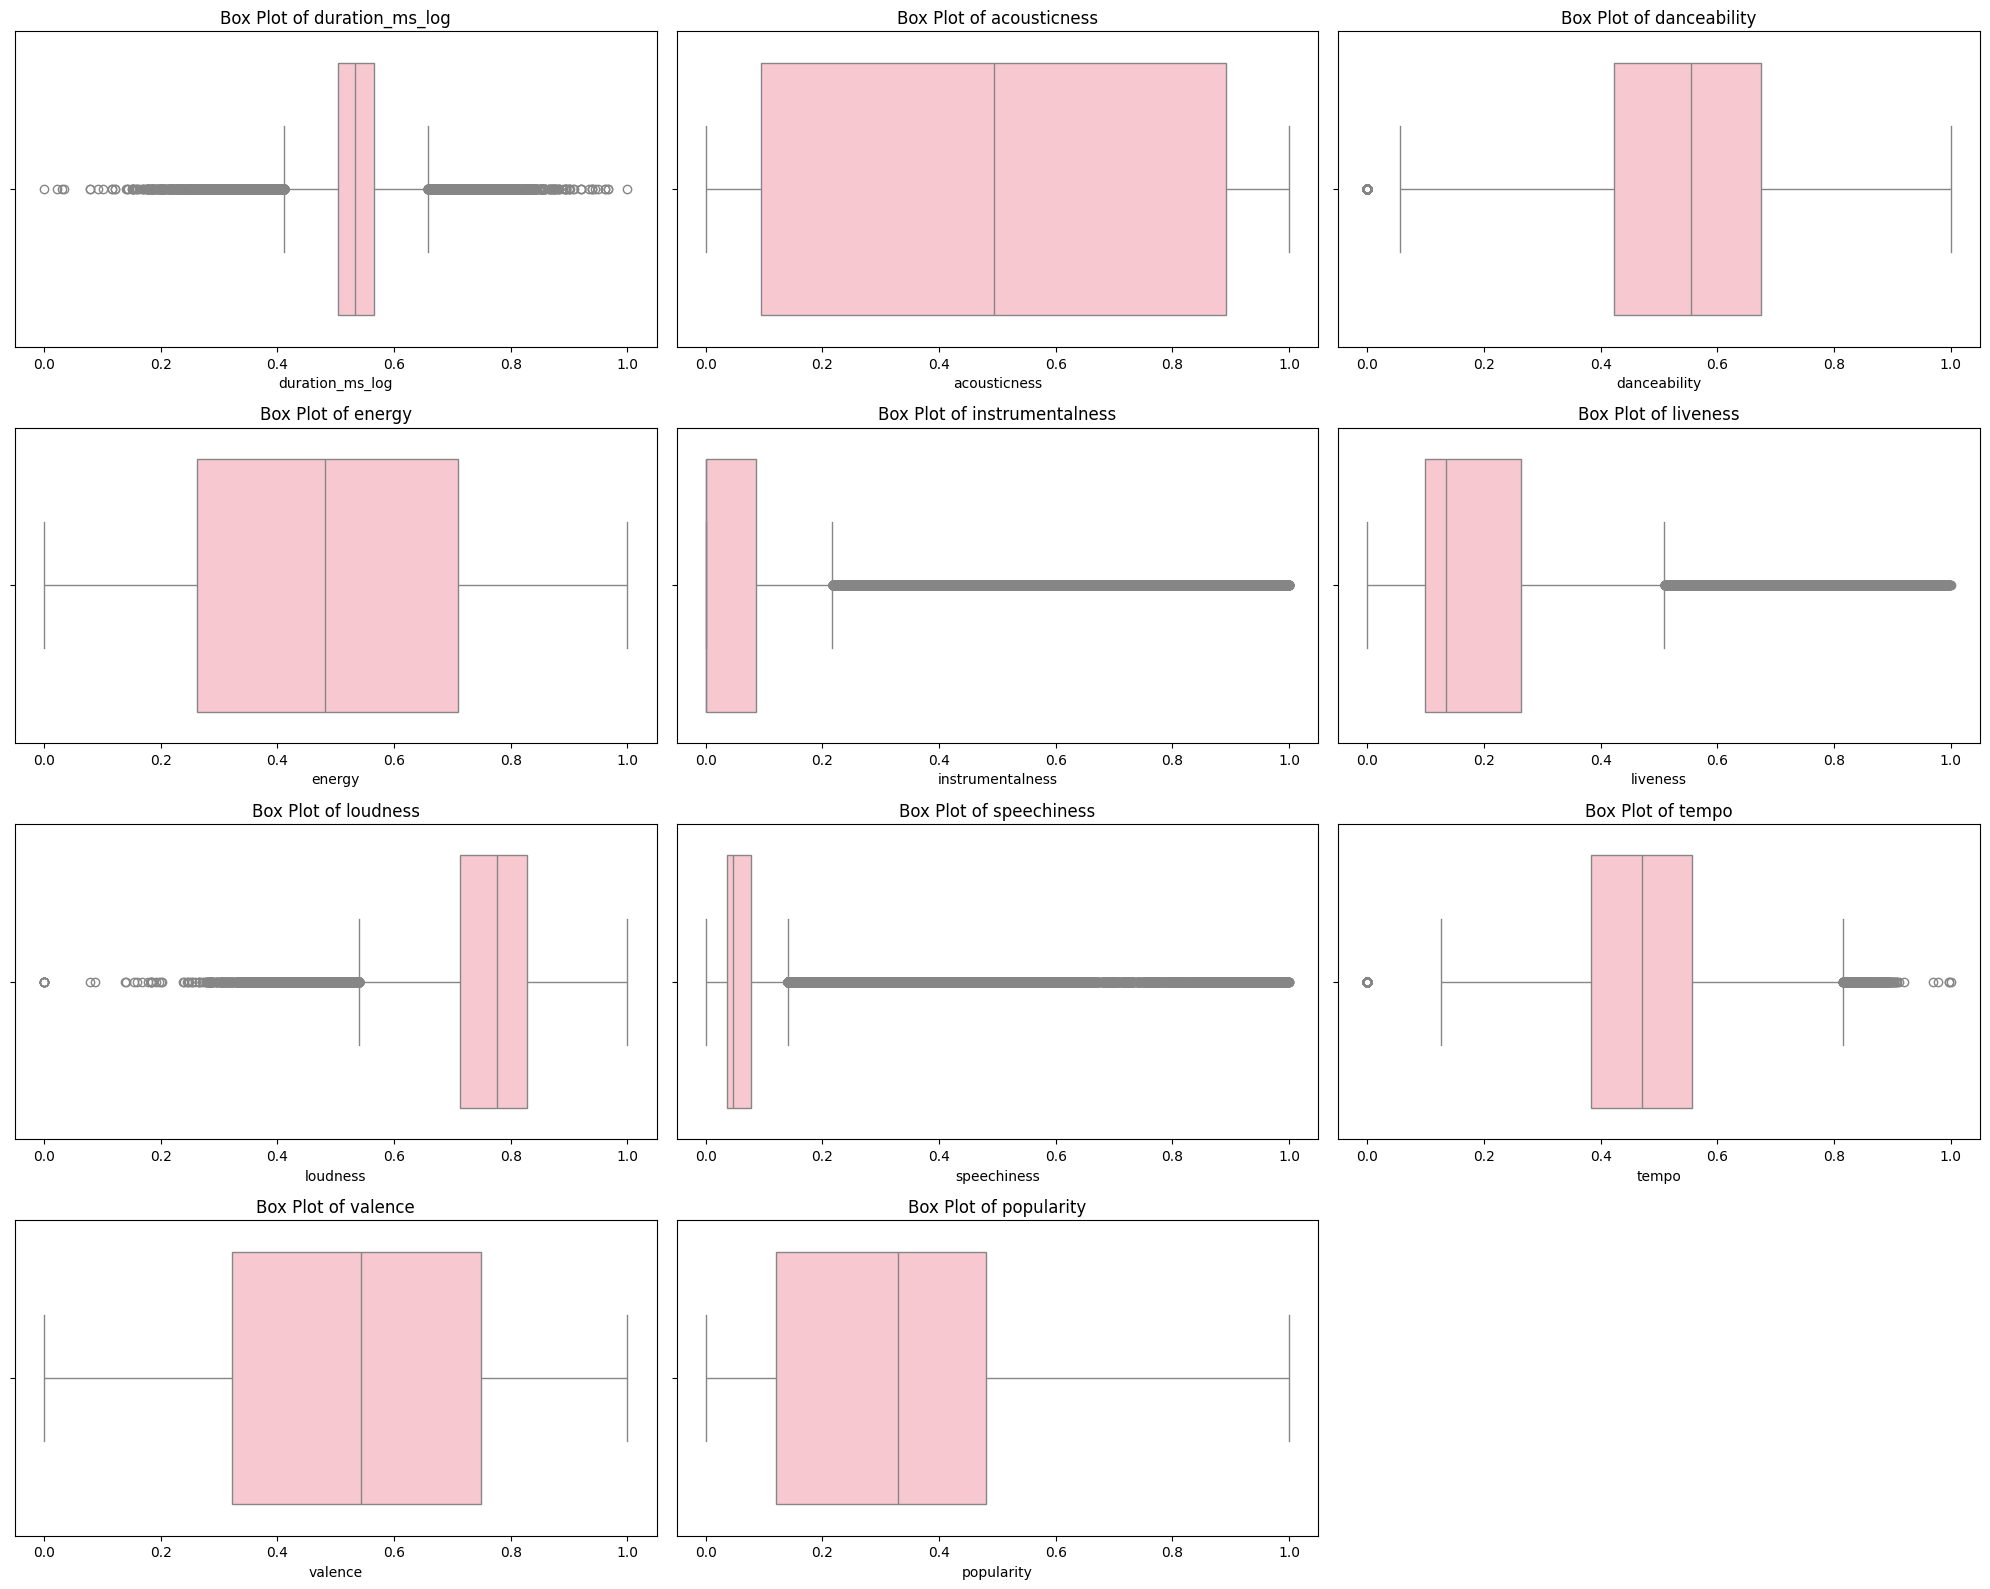

In [113]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the selected features
spot_normalized = spot.copy()
spot_normalized[new_numerical_features] = scaler.fit_transform(spot[new_numerical_features])

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for iteration

# Plot box plots for each feature
for i, feature in enumerate(new_numerical_features):
    sns.boxplot(x=spot_normalized[feature], color='pink', ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

# Hide any unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

## Part 4 Unsupervised Learning Models - Training, Building, and Results

Instructions: "Model building and training may depend on their data type(s) and task type(s). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. When using multiple models, at least one of them should be an unsupervised approach. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization."

### **K-Means Clustering**

As noted in the start, I will begin with kmeans clustering, where I will look to see how many clusters would be appropriate first using the elbow method. After that I will attempt to fit the model to the data and then label the data. Lastly I will use dimensionality reduction to visualize the output in 2 dimensions.

While I have shown up to 10 clusters on the graph, that is definitely overkill. It appears that using 3 or 4 is sufficient for our purposes. Note that at present we are training on all features of the normalized dataset (including the transformed duration).

Other hyperparameters include changing n_init or tolerance, but I have chosen to focus on the number of clusters for this particular project.

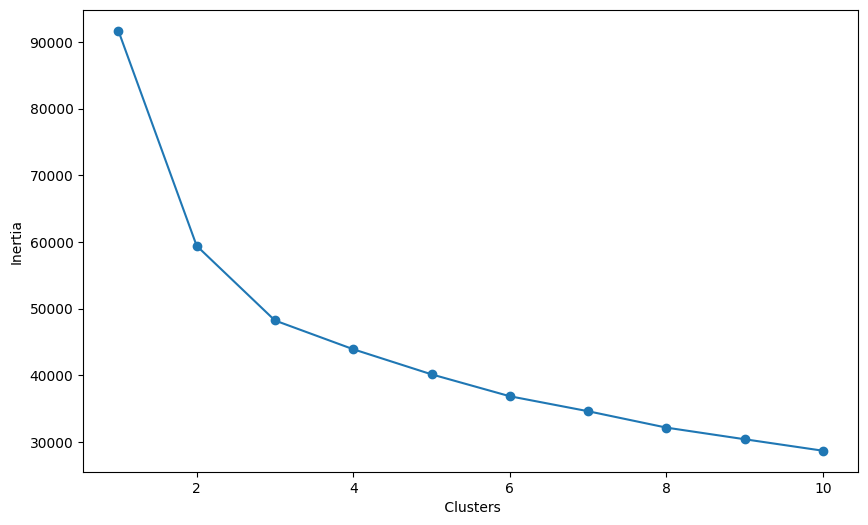

In [122]:
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=4)
    clusters = kmeans.fit_predict(data)
    return clusters, kmeans

# Determine the optimal number of clusters using the Elbow Method
def plot_elbow_method(data, max_clusters=10):
    inertia = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42,n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.xlabel(' Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Appears to be 3 or 4 giving the best result here.
plot_elbow_method(spot_normalized[new_numerical_features], max_clusters=10)

Inertia: 48205.56497542861


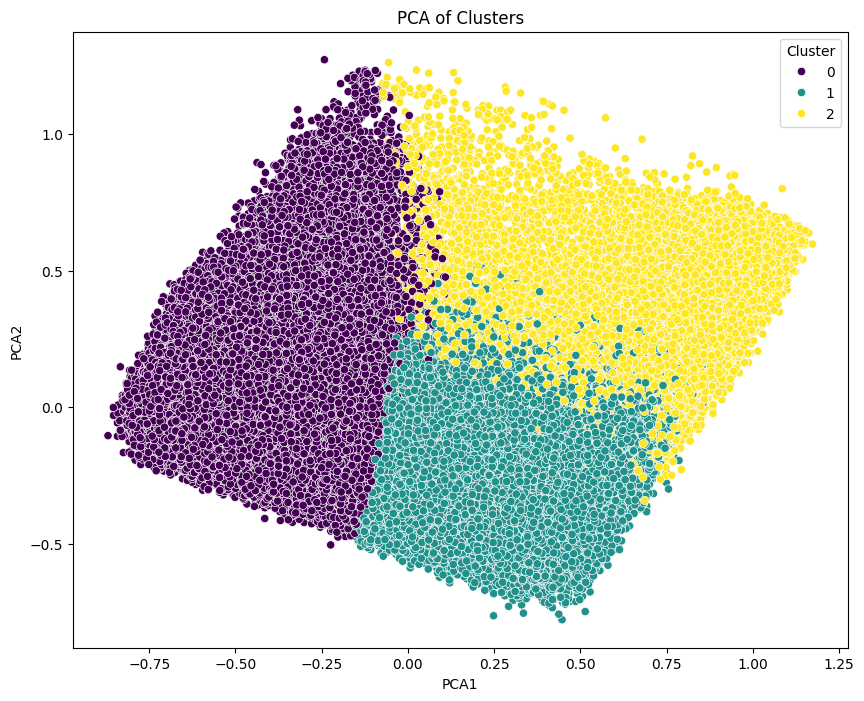

In [128]:
# Choose an appropriate number of clusters based on the Elbow Method
optimal_clusters = 3  # Replace this with the number
clusters, kmeans_model = apply_kmeans(spot_normalized[new_numerical_features], n_clusters=optimal_clusters)

# Add cluster labels to the dataset
spot_normalized['Cluster'] = clusters

# Reduce the data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(spot_normalized[new_numerical_features])

# Create a DataFrame with the PCA components and the cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = spot_normalized['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('PCA of Clusters')

# Calculate Inertia
print(f"Inertia: {kmeans_model.inertia_}")

### **But what do they *MEAN*?**

Looking at the different centers, it's obvious that some factors differ materially between clusters while others are less critical. The log duration of songs is almost identical in the three clusters, as is liveness. Others, such as instrumentalness and energy can vary more materially. This suggests that the factors provided by Spotify's algorithm, while imperfect, do a servicable job of separating the songs into certain groups, but not all features may be necessary depending on how granular you wish your groupings to be.

In [130]:
# Convert the cluster centers to a DataFrame
cluster_centers_df = pd.DataFrame(kmeans_model.cluster_centers_, columns=new_numerical_features)

# Display the cluster centers DataFrame
print(cluster_centers_df)

   duration_ms_log  acousticness  danceability    energy  instrumentalness  \
0         0.544816      0.155910      0.597103  0.689912          0.062630   
1         0.521361      0.798632      0.522530  0.312588          0.030314   
2         0.533020      0.891250      0.423409  0.243759          0.813502   

   liveness  loudness  speechiness     tempo   valence  popularity  
0  0.208752  0.812916     0.096835  0.503737  0.595649    0.442452  
1  0.213735  0.731103     0.111994  0.462160  0.500570    0.211786  
2  0.182696  0.664045     0.061574  0.438070  0.396375    0.143892  


## Non-Negative Matrix Factorization

Now let's look at NMF, which seeks to break down the data into a number of latent factors. These factors are comprised of the other features of the data and can be difficult to interpret at times. I myself am struggling with this a bit, although you can see some connections such as high energy and high danceability coinciding. My recommendation would be to use this as a secondary option behind k-means or other ML methods, potentially as a dimensionality reduction technique to facilitate data preprocessing before performing one of the other techniques.

   duration_ms_log  acousticness  danceability     energy  instrumentalness  \
0        12.122715     31.136967      7.961988   0.000000          0.000000   
1         2.489667      2.515267      0.000000   0.392717         25.759324   
2        19.819352      0.000000     14.457733  23.423378          0.000000   
3         1.627452      0.000000      8.032709   3.714324          0.000000   
4         1.865401      0.000000      0.000000   4.166743          0.000000   

   liveness   loudness  speechiness      tempo    valence  popularity  
0  3.264128  14.983100     1.180525   9.580116   2.411332    1.954913  
1  0.000000   1.254964     0.000000   1.442434   0.000000    0.000000  
2  0.000000  27.962363     0.000000  16.971001   0.000000   25.764856  
3  0.000000   3.823944     1.322732   2.365606  14.783643    0.000000  
4  5.938097   2.930538     1.380851   1.964933   0.818443    0.000000  


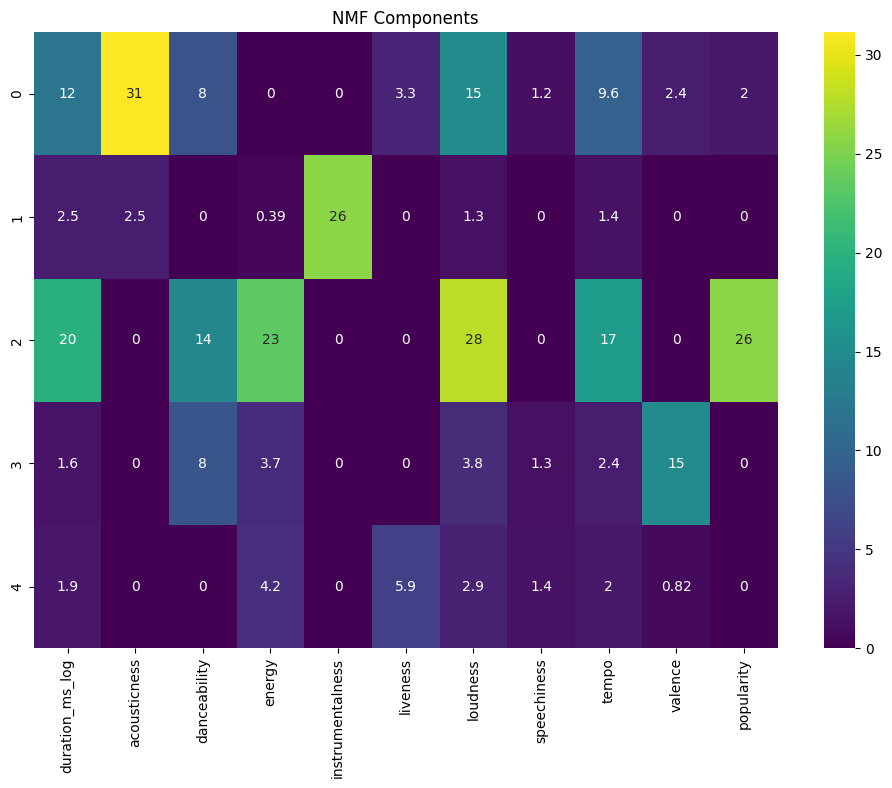

In [144]:
# exclude the 'Cluster' column
nmf_data = spot_normalized[new_numerical_features]

# Set the number of components (latent factors)
n_components = 5

# Initialize, fit, and transform model
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(nmf_data)
H = nmf_model.components_

# Convert the H matrix to a DataFrame for better readability
components_df = pd.DataFrame(H, columns=new_numerical_features)

# Display the components DataFrame
print(components_df)

# Plot the components
plt.figure(figsize=(12, 8))
sns.heatmap(components_df, annot=True, cmap='viridis')
plt.title('NMF Components')
plt.show()

   duration_ms_log  acousticness  danceability     energy  instrumentalness  \
0        10.488051     27.932248     10.551396   0.000000          0.000000   
1         3.509173      2.256751      0.000000   2.672281         18.882951   
2         8.003448      0.000000      9.307239  11.919630          0.000000   

   liveness   loudness  speechiness     tempo   valence  popularity  
0  4.295964  13.776947     2.284401  8.837250  9.752217    0.084028  
1  0.804143   3.195076     0.000000  2.501994  0.000000    1.099422  
2  3.181450  12.427046     1.467738  7.671929  9.645148    7.634581  


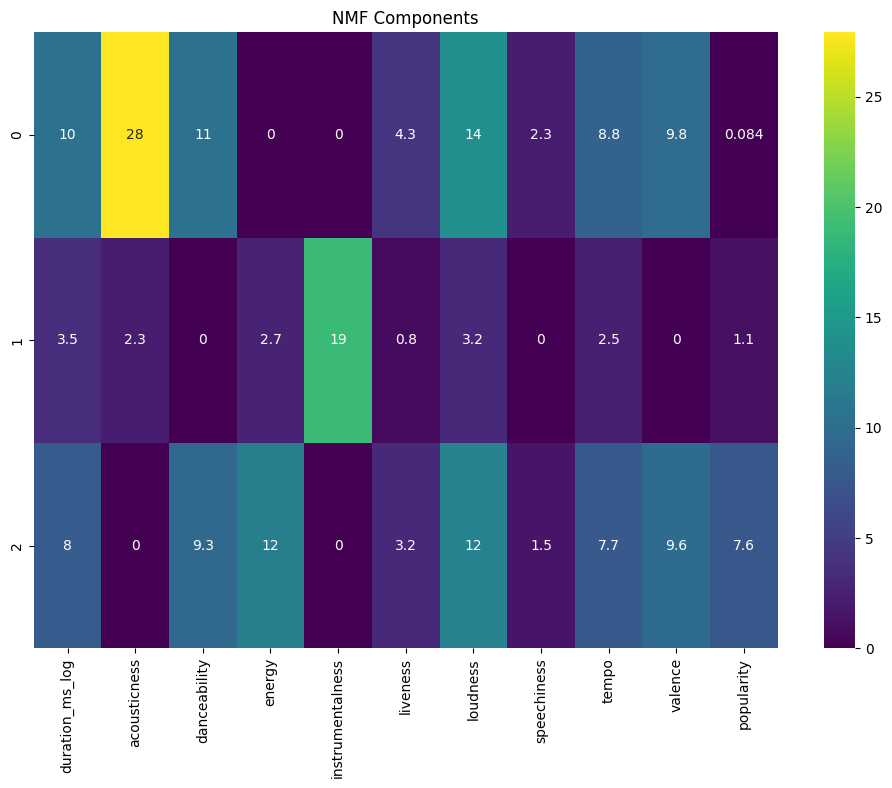

In [145]:
# exclude the 'Cluster' column
nmf_data = spot_normalized[new_numerical_features]

# Set the number of components (latent factors)
n_components = 3

# Initialize, fit, and transform model
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(nmf_data)
H = nmf_model.components_

# Convert the H matrix to a DataFrame for better readability
components_df = pd.DataFrame(H, columns=new_numerical_features)

# Display the components DataFrame
print(components_df)

# Plot the components
plt.figure(figsize=(12, 8))
sns.heatmap(components_df, annot=True, cmap='viridis')
plt.title('NMF Components')
plt.show()

## Discussion and Conclusion

Potential avenues for future expansion are:

1. Looking at differences over time or geography. We have data going back over a century, and I would be shocked if trends in Republican China matched those of Tory era Britain.
2. We could train our k_means on only a portion of the features rather than using the whole feature set. Right now I am pleased with the results, but if we can achieve similar results with fewer features that may mitigate the need for some dimensionality reduction.
3. Experiment with using NMF as a dimensionality reduction technique in conjunction with k-means rather than as a separate technique

As it stands, this analysis was revealing. It was able to show that the data provided by Spotify allows us to divide their data into different groups, which is definitely helpful for designing playlists, recommending artists, and even helping labels determine who to sign. My analysis here is obviously not a doctoral thesis and doesn't claim to have profound depth, but it does illustrate a proof of concept. These unsupervised learning techniques we have learned can hopefully be applied in new and interesting ways.